# Human Activity Recognition using smartphones

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:
#changing the working directory
%cd /content/gdrive/MyDrive/Kaggle
#Check the present working directory using pwd command

/content/gdrive/MyDrive/Kaggle


In [ ]:
%cd Activity_recognition

/content/gdrive/MyDrive/Kaggle/Activity_recognition


In [ ]:
#!kaggle datasets download -d uciml/human-activity-recognition-with-smartphones

In [ ]:
!pwd

/content/gdrive/MyDrive/Kaggle/Activity_recognition


In [ ]:
#%cd

/root


In [ ]:
#!mkdir Activity_recognition

In [ ]:
# import shutil
# import os
# shutil.move('./human-activity-recognition-with-smartphones.zip', './Activity_recognition')
# os.chdir('./Activity_recognition')
# !ls

In [ ]:
#!unzip human-activity-recognition-with-smartphones.zip

Archive:  human-activity-recognition-with-smartphones.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
!ls

Activity_recognition  test.csv	     train.csv
HARDataset	      Test_data.csv  Train_data.csv


### Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from collections import Counter

In [ ]:
from sklearn.linear_model import LogisticRegression

#### Helper functions for loading raw data

In [ ]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [ ]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

In [ ]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


In [ ]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
    print(testX.shape, testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
  
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy


### Loading the dataset

In [ ]:
trainX, trainy, testX, testy = load_dataset()

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 1) (2947, 128, 9) (2947, 1)


### Feature extraction for train dataset

In [ ]:
mean=trainX.mean(axis=1)
max_values = np.amax(trainX, axis=1)
min_values = np.amin(trainX, axis=1)
mean.shape, max_values.shape, min_values.shape

((7352, 9), (7352, 9), (7352, 9))

In [ ]:
X_train = np.c_[mean, max_values, min_values, trainy]
X_train.shape
df_train  = pd.DataFrame(X_train)

### Feature extraction for test dataset

In [ ]:
mean=testX.mean(axis=1)
max_values = np.amax(testX, axis=1)
min_values = np.amin(testX, axis=1)
mean.shape, max_values.shape, min_values.shape

((2947, 9), (2947, 9), (2947, 9))

In [ ]:
X_test = np.c_[mean, max_values, min_values, testy]
df_test = pd.DataFrame(X_test)
X_test.shape

(2947, 28)

In [ ]:
columns = ["AccTotalX-mean","AccTotalX-max","AccTotalX-min" ,  "AccTotalY-mean","AccTotalY-max","AccTotalY-min",  "AccTotalZ-mean","AccTotalZ-max","AccTotalZ-min" ,  "AccBodyX-mean","AccBodyX-max","AccBodyX-min" ,  "AccBodyY-mean","AccBodyY-max","AccBodyY-min",  "AccBodyZ-mean","AccBodyZ-max","AccBodyZ-min" ,  "GyroX-mean","GyroX-max","GyroX-min" ,  "GyroY-mean","GyroY-max","GyroY-min",  "GyroZ-mean","GyroZ-max","GyroZ-min" , "Activity"]

In [ ]:
df_train.columns = columns
df_test.columns = columns


df_train["Activity"] = df_train["Activity"].map({5:'LAYING',4: 'STANDING', 3: "SITTING", 0:'WALKING', 1:'WALKING_UPSTAIRS', 2:'WALKING_DOWNSTAIRS'})
df_test["Activity"] = df_test["Activity"].map({5:'LAYING',4: 'STANDING', 3: "SITTING", 0:'WALKING', 1:'WALKING_UPSTAIRS', 2:'WALKING_DOWNSTAIRS'})


### Explortory Data Analysis

In [ ]:
# showing the first 5 rows of the dataset
df_train.head()

,AccTotalX-mean,AccTotalX-max,AccTotalX-min,AccTotalY-mean,AccTotalY-max,AccTotalY-min,AccTotalZ-mean,AccTotalZ-max,AccTotalZ-min,AccBodyX-mean,AccBodyX-max,AccBodyX-min,AccBodyY-mean,AccBodyY-max,AccBodyY-min,AccBodyZ-mean,AccBodyZ-max,AccBodyZ-min,GyroX-mean,GyroX-max,GyroX-min,GyroY-mean,GyroY-max,GyroY-min,GyroZ-mean,GyroZ-max,GyroZ-min,Activity
0,1.019305,-0.124262,0.099732,0.002269,-0.001655,-0.008126,0.022250,0.019403,0.009468,1.024606,-0.117210,0.109485,0.010810,0.010767,0.055561,0.050545,0.074850,0.022859,1.012817,-0.132631,0.088742,-0.004294,-0.012610,-0.033006,-0.003862,-0.009022,-0.006891,STANDING
1,1.019448,-0.122936,0.096939,0.000174,0.000382,-0.005025,0.011926,-0.004314,0.006308,1.024606,-0.108560,0.105788,0.005251,0.016634,0.012660,0.055249,0.016858,0.025133,1.012893,-0.132631,0.081100,-0.006706,-0.012610,-0.026860,-0.038650,-0.030160,-0.009759,STANDING
2,1.019927,-0.124997,0.092897,0.000428,-0.001222,-0.001703,-0.004150,-0.012640,0.004335,1.027664,-0.108560,0.105788,0.008167,0.016634,0.012660,0.055249,0.000761,0.028609,1.009013,-0.137142,0.081100,-0.010483,-0.015333,-0.014596,-0.038650,-0.037503,-0.009759,STANDING
3,1.020349,-0.130493,0.087654,0.000329,-0.004753,-0.004947,-0.016228,-0.007697,-0.000352,1.027664,-0.116749,0.098737,0.008167,0.005359,0.006107,0.010361,0.007778,0.028609,1.009013,-0.143545,0.076888,-0.010483,-0.015333,-0.015679,-0.037516,-0.037503,-0.013223,STANDING
4,1.020255,-0.130209,0.084999,-0.000195,0.000298,-0.002330,-0.006483,-0.000166,-0.003957,1.026194,-0.121456,0.093388,0.005650,0.009661,0.009009,0.043706,0.017447,0.019890,1.013645,-0.143545,0.074595,-0.006847,-0.014662,-0.015679,-0.024902,-0.020582,-0.021141,STANDING


### The experiment

The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz.

The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window).

### Visualising raw data



In [ ]:
sample = pd.DataFrame(trainX[0])
x,y = np.meshgrid(sample.columns.astype(float), sample.index)
z = sample.values

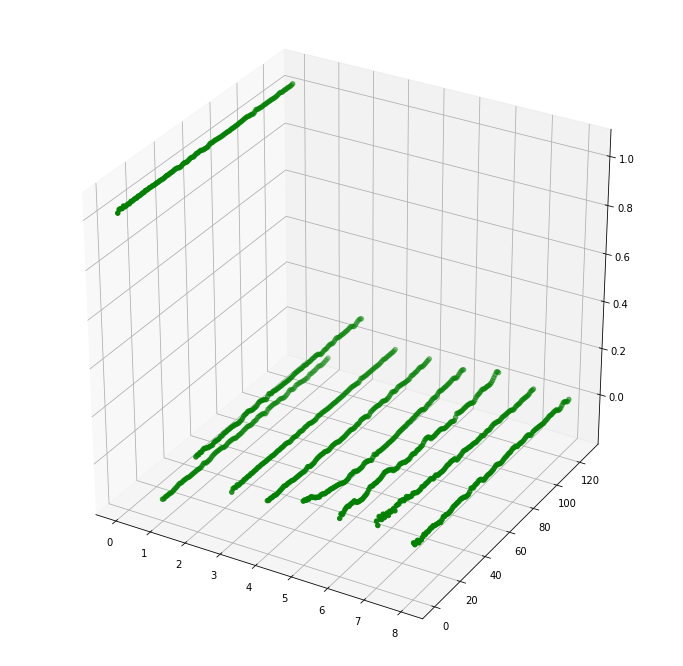

In [ ]:
fig = plt.figure(figsize=(12,12)) 
  
ax = plt.axes(projection ='3d') 
ax.scatter3D(x,y,z,'0',color="green")

##### Visualising one sensor reading

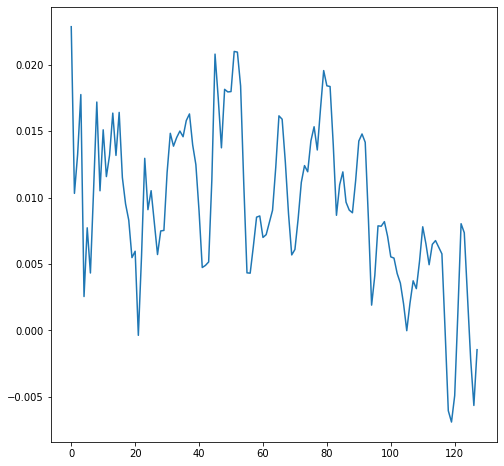

In [ ]:
fig = plt.figure(figsize=(8,8)) 
plt.plot(sample.index,sample[8])

In [ ]:
# Number of samples in each activity
df_train['Activity'].value_counts()

LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: Activity, dtype: int64

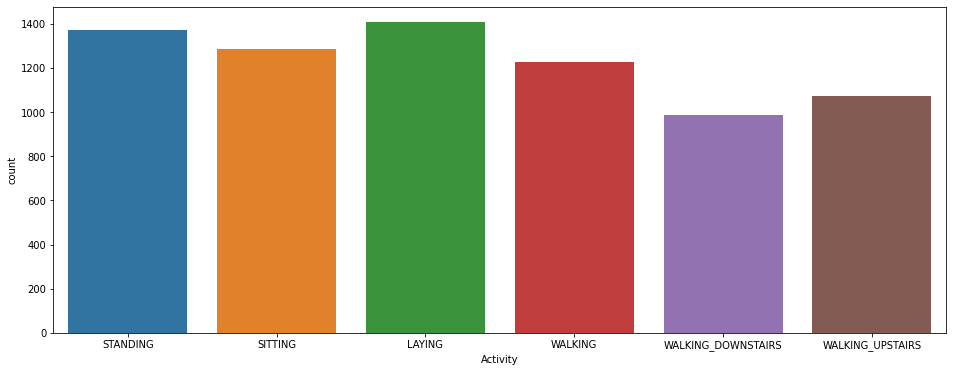

In [ ]:
# Plotting the Activities distribution
plt.figure(figsize=(16,6))
sns.countplot(x = 'Activity',data = df_train)

All the classes have an almost equal number of sample. The data is not skewed

#### The features

The acceleration signal is separated into body and gravity acceleration signals (tBodyAcc-XYZ and tGravityAcc-XYZ). The acceleration is further divided into mean, min and max values.





#### Major features in this dataset

In [ ]:
pd.DataFrame.from_dict(Counter([col.split('-')[0] for col in df_train.columns]), orient='index')

,0
AccTotalX,3
AccTotalY,3
AccTotalZ,3
AccBodyX,3
AccBodyY,3
AccBodyZ,3
GyroX,3
GyroY,3
GyroZ,3
Activity,1


#### Visualising the data in a two dimensional space 

In [ ]:
# compressing the data to 2 dimension
tsne = TSNE(random_state = 42, n_components = 2, verbose = 1, n_iter = 1000).fit_transform(df_train.drop(columns='Activity'))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.021s...
[t-SNE] Computed neighbors for 7352 samples in 0.731s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 0.087986
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.963898
[t-SNE] KL divergence after 1000 iterations: 0.867564


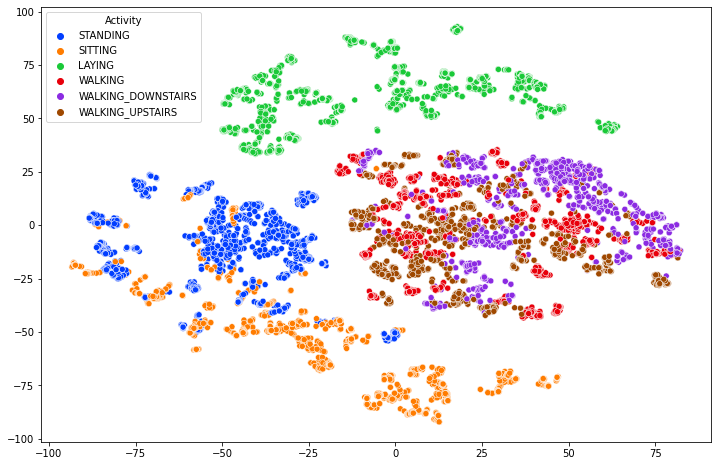

In [ ]:
plt.figure(figsize = (12,8))
sns.scatterplot(x = tsne[:,0], y = tsne[:,1], hue = df_train["Activity"], palette = "bright")

**Observations**:

1. Walking, Walking_downstaris, Walking_upstairs are similar

2. Standing and Sitting are also similar.

3. Laying is clearly seperated from the rest of the classes







### Static and dynamic activities

Static and Dynamic Activites
Static activities are (sit, stand, lie and down) thus there is no any motion of an object.

Dynamic activities (Walking, WalkingUpStairs, WalkingDownStairs) motion info will be significant

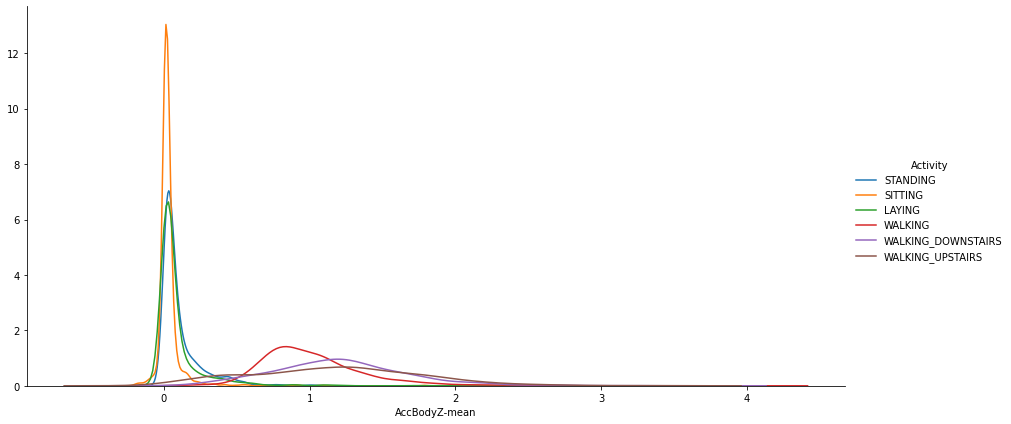

In [ ]:
facetgrid = sns.FacetGrid(df_train, hue='Activity', height=6,aspect=2)
facetgrid.map(sns.kdeplot,'AccBodyZ-mean',)
facetgrid.add_legend()


We can see that static activities like standing are highly localised and have a lower varience compared to dynamic activities like walking, whereas the dynamic activities like walking is more spread out

### Data cleanup and preprocessing

##### Checking for null values

In [ ]:
print("Total null values in train dataset",df_train.isnull().values.sum())
print("Total null values in test dataset",df_test.isnull().values.sum())

Total null values in train dataset 0
Total null values in test dataset 0


### Creating the inputs and corresponding output labels

##### Input data

In [ ]:
X_train = df_train[df_train.columns[:-1]]

In [ ]:
X_test = df_test[df_test.columns[:-1]]

###### Output labels

In [ ]:
y_train = df_train['Activity']

In [ ]:
y_test = df_test['Activity']

In [ ]:
# mapping the string labels into numeric values
y_train = y_train.map({'LAYING': 0, 'STANDING': 1, "SITTING": 2, 'WALKING': 3, 'WALKING_UPSTAIRS': 4, 'WALKING_DOWNSTAIRS': 5})

y_test = y_test.map({'LAYING': 0, 'STANDING': 1, "SITTING": 2, 'WALKING': 3, 'WALKING_UPSTAIRS': 4, 'WALKING_DOWNSTAIRS': 5})

In [ ]:
y_train

0       1
1       1
2       1
3       1
4       1
       ..
7347    4
7348    4
7349    4
7350    4
7351    4
Name: Activity, Length: 7352, dtype: int64

# Machine Learning Algorithms

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score


### Model tuning and evaluation methods

In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    print("Training accuracy: " + str(model.score(X_train, y_train)))
    print("Testing accuracy: " + str(model.score(X_test, y_test)))
    y_pred = model.predict(X_test)


In [ ]:
def tune_parameters(model, X_train, y_train, param_grid, verbose=False, cv=5):
    clf = GridSearchCV(model, param_grid=param_grid, cv=cv, n_jobs=-1, return_train_score=True)
    clf.fit(X_train, y_train)
    results = clf.cv_results_

    if verbose:
        plt.figure()
        plt.plot(results['param_C'], results['mean_train_score'])
        plt.plot(results['param_C'], results['mean_test_score'])
        plt.xlabel(list(param_grid.keys())[0])
        plt.ylabel("Accuracy")
        plt.show()

    return clf

### Logistic regression

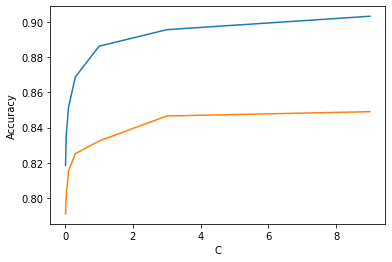

In [ ]:

parameters = {'C': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 9.0]}

log_reg = LogisticRegression(max_iter=10000)
grid_search = tune_parameters(log_reg, X_train, y_train, parameters, verbose=True)  


In [ ]:
log_reg_best = grid_search.best_estimator_
evaluate_model(log_reg_best, X_train, X_test, y_train, y_test)

Training accuracy: 0.8954026115342764
Testing accuracy: 0.8106549032914828


Logistic regression acheived an accuracy of 81.06% on the test dataset



### SVM

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


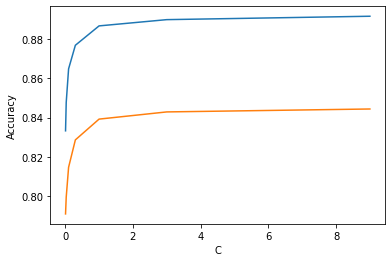

In [ ]:
parameters = {'C': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 9.0]}
svm = LinearSVC(C=10, max_iter=10000)
grid_search = tune_parameters(svm, X_train, y_train, parameters, verbose=True)  


In [ ]:
svm_best = grid_search.best_estimator_
evaluate_model(svm_best, X_train, X_test, y_train, y_test)

Training accuracy: 0.8847932535364527
Testing accuracy: 0.823210044112657


SVM acheived an accuracy of 81.5% on the test dataset

In [ ]:
y_train

0       1
1       1
2       1
3       1
4       1
       ..
7347    4
7348    4
7349    4
7350    4
7351    4
Name: Activity, Length: 7352, dtype: int64

In [ ]:
X_train.shape

(7352, 27)

## Deep learning models

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
model = Sequential()
model.add(Dense(54,tf.keras.activations.relu))
model.add(tf.keras.layers.Dropout(0.3))
model.add(Dense(27,tf.keras.activations.relu))
model.add(tf.keras.layers.Dropout(0.3))
model.add(Dense(13,tf.keras.activations.relu))
model.add(tf.keras.layers.Dropout(0.1))
model.add(Dense(7,tf.keras.activations.relu))
model.add(Dense(6, tf.keras.activations.softmax))


model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer="adam",
              metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=20)

In [ ]:
model.fit(x=X_train,y=y_train,epochs=100,batch_size=100,verbose=1,validation_data=(X_test,y_test),callbacks=[early_stop])

Epoch 1/100
74/74 [==============================] - 4s 6ms/step - loss: 1.7345 - accuracy: 0.2290 - val_loss: 1.2074 - val_accuracy: 0.5524
Epoch 2/100
74/74 [==============================] - 0s 3ms/step - loss: 1.1351 - accuracy: 0.5131 - val_loss: 0.7635 - val_accuracy: 0.6142
Epoch 3/100
74/74 [==============================] - 0s 3ms/step - loss: 0.8250 - accuracy: 0.5810 - val_loss: 0.7379 - val_accuracy: 0.6179
Epoch 4/100
74/74 [==============================] - 0s 3ms/step - loss: 0.7576 - accuracy: 0.6137 - val_loss: 0.7096 - val_accuracy: 0.6298
Epoch 5/100
74/74 [==============================] - 0s 3ms/step - loss: 0.7191 - accuracy: 0.6422 - val_loss: 0.6972 - val_accuracy: 0.6671
Epoch 6/100
74/74 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.6603 - val_loss: 0.6813 - val_accuracy: 0.6732
Epoch 7/100
74/74 [==============================] - 0s 3ms/step - loss: 0.6663 - accuracy: 0.6802 - val_loss: 0.6718 - val_accuracy: 0.6878
Epoch 8/100
7

In [ ]:
losses = pd.DataFrame(model.history.history)

In [ ]:
losses.head()

,loss,accuracy,val_loss,val_accuracy
0,1.627491,0.312024,1.207420,0.552426
1,1.006850,0.545702,0.763461,0.614184
2,0.805098,0.590316,0.737897,0.617917
3,0.741460,0.625000,0.709574,0.629793
4,0.702915,0.648259,0.697216,0.667119


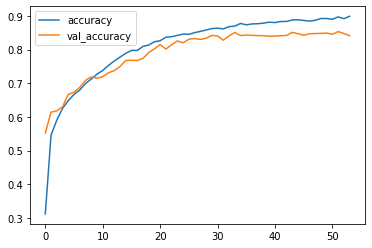

In [ ]:
losses[['accuracy','val_accuracy']].plot()

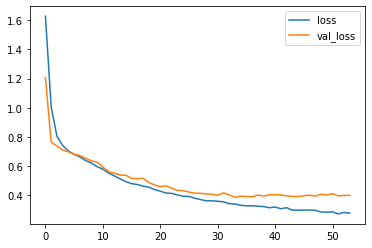

In [ ]:
losses[['loss','val_loss']].plot()

In [ ]:
predictions = model.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
predictions - y_test

0       0
1       0
2       0
3       0
4       0
       ..
2942    0
2943   -1
2944   -1
2945    0
2946    0
Name: Activity, Length: 2947, dtype: int64

In [ ]:
np.count_nonzero(predictions - y_test)

468

In [ ]:
(y_test.shape[0]- np.count_nonzero(predictions - y_test))/y_test.shape[0]

0.8411944350186631

## LSTM

In [ ]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]


In [ ]:
n_outputs


1

In [ ]:
lstmModel = Sequential()
lstmModel.add(tf.keras.layers.LSTM(100, input_shape=(n_timesteps,n_features)))
lstmModel.add(tf.keras.layers.Dropout(0.5))
lstmModel.add(Dense(100, activation='relu'))
lstmModel.add(Dense(6, activation='softmax'))

lstmModel.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

In [ ]:
lstmModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               44000     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 606       
Total params: 54,706
Trainable params: 54,706
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstmModel.fit(trainX, trainy, epochs=15, batch_size=64, verbose=1)
# evaluate model
_, accuracy = lstmModel.evaluate(testX, testy, batch_size=64, verbose=0)


Epoch 1/15
115/115 [==============================] - 31s 9ms/step - loss: 1.3902 - accuracy: 0.4143
Epoch 2/15
115/115 [==============================] - 1s 8ms/step - loss: 0.7451 - accuracy: 0.6873
Epoch 3/15
115/115 [==============================] - 1s 8ms/step - loss: 0.6696 - accuracy: 0.7290
Epoch 4/15
115/115 [==============================] - 1s 8ms/step - loss: 0.4785 - accuracy: 0.8199
Epoch 5/15
115/115 [==============================] - 1s 8ms/step - loss: 0.5883 - accuracy: 0.7698
Epoch 6/15
115/115 [==============================] - 1s 8ms/step - loss: 0.2742 - accuracy: 0.9062
Epoch 7/15
115/115 [==============================] - 1s 8ms/step - loss: 0.2255 - accuracy: 0.9210
Epoch 8/15
115/115 [==============================] - 1s 8ms/step - loss: 0.2560 - accuracy: 0.9120
Epoch 9/15
115/115 [==============================] - 1s 8ms/step - loss: 0.1726 - accuracy: 0.9377
Epoch 10/15
115/115 [==============================] - 1s 8ms/step - loss: 0.1494 - accuracy: 0.940

In [ ]:
accuracy

0.8971835970878601

In [ ]:
Xtrain = np.expand_dims(trainX,3)
Xtrain.shape

(7352, 128, 9, 1)

In [ ]:
Xtest = np.expand_dims(testX,3)
Xtest.shape

(2947, 128, 9, 1)

In [ ]:
model = Sequential()

## FIRST SET OF LAYERS

# CONVOLUTIONAL LAYERS
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(2,2),input_shape=(128,9,1), activation='relu',))

# POOLING LAYER
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

## SECOND SET OF LAYERS

# CONVOLUTIONAL LAYERS
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu',))

model.add(tf.keras.layers.Flatten())

# 256 NEURONS IN DENSE HIDDEN LAYER 
model.add(Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
# LAST LAYER IS THE CLASSIFIER, 10 POSSIBLE CLASSES
model.add(Dense(6, activation='softmax'))


model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 127, 8, 16)        80        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 4, 16)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 62, 3, 32)         2080      
_________________________________________________________________
flatten_4 (Flatten)          (None, 5952)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               1523968   
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 6)               

In [ ]:
model.fit(Xtrain, trainy, epochs=15, batch_size=64, verbose=1)

Epoch 1/15
115/115 [==============================] - 1s 5ms/step - loss: 0.7402 - accuracy: 0.6829
Epoch 2/15
115/115 [==============================] - 1s 5ms/step - loss: 0.2691 - accuracy: 0.8939
Epoch 3/15
115/115 [==============================] - 1s 5ms/step - loss: 0.1895 - accuracy: 0.9306
Epoch 4/15
115/115 [==============================] - 1s 5ms/step - loss: 0.1474 - accuracy: 0.9474
Epoch 5/15
115/115 [==============================] - 1s 5ms/step - loss: 0.1224 - accuracy: 0.9568
Epoch 6/15
115/115 [==============================] - 1s 5ms/step - loss: 0.1148 - accuracy: 0.9520
Epoch 7/15
115/115 [==============================] - 1s 5ms/step - loss: 0.1010 - accuracy: 0.9602
Epoch 8/15
115/115 [==============================] - 1s 5ms/step - loss: 0.0838 - accuracy: 0.9666
Epoch 9/15
115/115 [==============================] - 1s 5ms/step - loss: 0.0930 - accuracy: 0.9605
Epoch 10/15
115/115 [==============================] - 1s 5ms/step - loss: 0.0811 - accuracy: 0.9639

In [ ]:
_, accuracyCNN = model.evaluate(Xtest, testy, batch_size=64, verbose=0)


In [ ]:
accuracyCNN

0.8907363414764404

In [ ]:
losses = pd.DataFrame(model.history.history)

In [ ]:
SimpleRnn = Sequential()
SimpleRnn.add(tf.keras.layers.SimpleRNN(100, input_shape=(n_timesteps,n_features)))
#SimpleRnn.add(tf.keras.layers.Dropout(0.2))
SimpleRnn.add(Dense(100, activation='relu'))
SimpleRnn.add(Dense(6, activation='softmax'))

SimpleRnn.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer='RMSprop', metrics=['accuracy'])

In [ ]:
SimpleRnn.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 100)               11000     
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 606       
Total params: 21,706
Trainable params: 21,706
Non-trainable params: 0
_________________________________________________________________


In [ ]:
SimpleRnn_history= SimpleRnn.fit(trainX, trainy, epochs=15, batch_size=256, verbose=1,validation_data=(testX,testy),shuffle=True)
# evaluate model
_, accuracy = SimpleRnn.evaluate(testX, testy, batch_size=256, verbose=0)


Epoch 1/15
29/29 [==============================] - 3s 115ms/step - loss: 0.1651 - accuracy: 0.9446 - val_loss: 0.3201 - val_accuracy: 0.8887
Epoch 2/15
29/29 [==============================] - 3s 115ms/step - loss: 0.1142 - accuracy: 0.9540 - val_loss: 0.2941 - val_accuracy: 0.9080
Epoch 3/15
29/29 [==============================] - 3s 111ms/step - loss: 0.2135 - accuracy: 0.9370 - val_loss: 0.3795 - val_accuracy: 0.8819
Epoch 4/15
29/29 [==============================] - 3s 113ms/step - loss: 0.1117 - accuracy: 0.9528 - val_loss: 0.3898 - val_accuracy: 0.8765
Epoch 5/15
29/29 [==============================] - 3s 111ms/step - loss: 0.1245 - accuracy: 0.9482 - val_loss: 0.3363 - val_accuracy: 0.8951
Epoch 6/15
29/29 [==============================] - 3s 114ms/step - loss: 0.1708 - accuracy: 0.9361 - val_loss: 0.3181 - val_accuracy: 0.8812
Epoch 7/15
29/29 [==============================] - 3s 112ms/step - loss: 0.1183 - accuracy: 0.9529 - val_loss: 0.2810 - val_accuracy: 0.8992
Epoch 

In [ ]:
accuracy

0.8985409140586853

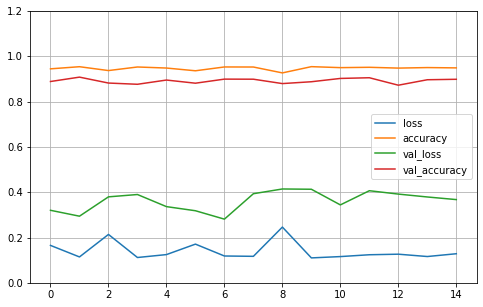

In [ ]:
# Plotting accuracy, loss vs Epochs
pd.DataFrame(SimpleRnn_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1.2) # set the vertical range to[0-1]
plt.show()

In [ ]:
lossSimpleRnn= pd.DataFrame(SimpleRnn_history.history)

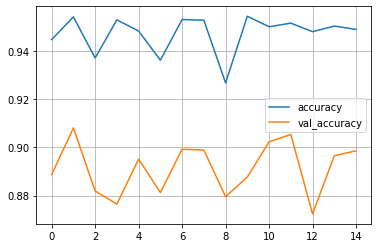

In [ ]:
lossSimpleRnn[['accuracy','val_accuracy']].plot()
plt.grid(True)

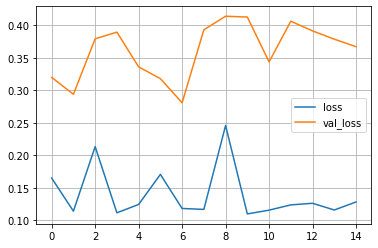

In [ ]:
lossSimpleRnn[['loss','val_loss']].plot()
plt.grid(True)